In [1]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from random import randint
import random
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset
global  samplesJoint,tp_dataloader,tp_dataloader_testing,dp,decision,dp_H,decision_H
from pylab import *
from scipy.stats import beta
import math
n = 5
epochs = 3
supervisionEpochs = 2
lr = 0.0001
log_interval = 20
trainSize = 60000#100000
percentage_train_test= 0.25
penaltyLambda = 10

doublePeakHighMean = 0.9
doublePeakLowMean = 0.1
doublePeakStd = 0.1

d1 = D.normal.Normal(doublePeakLowMean, doublePeakStd)
d2 = D.normal.Normal(doublePeakHighMean, doublePeakStd)
distributionRatio = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase = d1.cdf(0) + d2.cdf(0)


def cdf(x, i=None):
    return (d1.cdf(x) + d2.cdf(x) - distributionBase) / 2 / distributionRatio

# def cdf(x, i=None):
#     if x < 0.1:
#         return 0
#     if x <= 0.2:
#         return 0.5 * (x - 0.1) / 0.1
#     if x < 0.8:
#         return 0.5
#     if x < 0.9:
#         return 0.5 + 0.5 * (x - 0.8) / 0.1
#     return 1


print(distributionBase)

tensor(0.1587)


In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


loc 0.1 scale 0.1
loc 0.9 scale 0.1


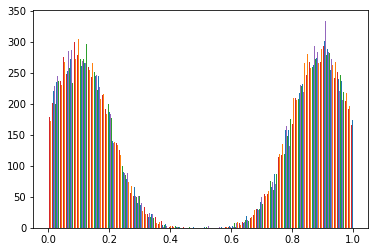

In [3]:
print("loc",doublePeakLowMean, "scale",doublePeakStd)
print("loc",doublePeakHighMean, "scale",doublePeakStd)
signals = np.random.randint(2, size=(trainSize, n))
samples1 = np.random.normal(
    loc=doublePeakLowMean, scale=doublePeakStd, size=(trainSize, n)
)
for i in range(trainSize):
    for j in range(n):
        while samples1[i, j] < 0 or samples1[i, j] > 1:
            samples1[i, j] = np.random.normal(
                loc=doublePeakLowMean, scale=doublePeakStd
            )
samples2 = np.random.normal(
    loc=doublePeakHighMean, scale=doublePeakStd, size=(trainSize, n)
)
for i in range(trainSize):
    for j in range(n):
        while samples2[i, j] < 0 or samples2[i, j] > 1:
            samples2[i, j] = np.random.normal(
                loc=doublePeakHighMean, scale=doublePeakStd
            )
samplesJoint = signals * samples1 - (signals - 1) * samples2
tp_tensor = torch.tensor(samplesJoint, dtype=torch.float32)

# tp_tensor = torch.tensor(np.random.rand(10000, n), dtype=torch.float32)
plt.hist(samplesJoint,bins=500)
plt.show()

tp_dataset = TensorDataset(tp_tensor[: int(trainSize * percentage_train_test)])
tp_dataset_testing = TensorDataset(tp_tensor[int(trainSize * (1.0-percentage_train_test)) :])
tp_dataloader = DataLoader(tp_dataset, batch_size=128, shuffle=True)
tp_dataloader_testing = DataLoader(tp_dataset_testing, batch_size=256, shuffle=False)





In [4]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [5]:
# Instantiate the model with hyperparameters
model = Model(input_size=n, output_size=n, hidden_dim=100, n_layers=3)
print(model)

Model(
  (rnn): RNN(5, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)


In [6]:


# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
def bitsToPayments(bits):
    if torch.sum(bits).item() == 0:
        return torch.ones(n)
    bits = bits.type(torch.float32)
    negBits = torch.ones(n) - bits
    bits=torch.reshape(bits,(1,-1,n))
    payments = model(bits)
    payments=payments[0].view(n)
    payments = payments - 1000 * negBits
    payments = torch.softmax(payments, 0)
    payments = payments + negBits
    return payments


def tpToBits(tp, deep , bits=torch.ones(n).type(torch.float32)):
    payments = bitsToPayments(bits)
    newBits = torch.sigmoid((tp-payments+0.0001)/0.000001);
    
    if torch.allclose(newBits, bits) or deep >= n:
        return bits
    else:
        return tpToBits(tp,deep+1, newBits)


def tpToPayments(tp):
    return bitsToPayments(tpToBits(tp,0))


def tpToTotalDelay(tp):
    return n - torch.sum(tpToBits(tp,0).type(torch.float32))


In [8]:
def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [9]:
print(1_000_000)
print(cdf(0.5))

1000000
tensor(0.5000)


In [10]:
print(tp_dataset_testing[0:1])
#inputt= one_hot_encode(tp_dataset_testing, n, 1, 1)
print(torch.ones(n))

inputxx=torch.from_numpy(np.asarray([t.numpy() for t in tp_dataset_testing[0:1]]))
print(inputxx.shape)

yy=model(inputxx)
print(len(yy[0][0]))
print(yy[1])
print(yy[0].shape)

(tensor([[0.8316, 0.0939, 0.9443, 0.1167, 0.1324]]),)
tensor([1., 1., 1., 1., 1.])
torch.Size([1, 1, 5])
5
tensor([[[ 0.0447,  0.0418,  0.0767, -0.0332, -0.0906,  0.0339, -0.0407,
           0.1891, -0.1019,  0.2054, -0.1405, -0.1241, -0.0495,  0.2708,
           0.0527, -0.0336,  0.0179,  0.0439,  0.1567,  0.0240, -0.0510,
           0.0417, -0.0138, -0.0695,  0.1352,  0.0751, -0.0193, -0.0656,
          -0.0404, -0.0500, -0.0028,  0.0511,  0.0381,  0.0463,  0.0178,
          -0.0515,  0.0029, -0.0383,  0.0889, -0.0286, -0.0964, -0.1119,
          -0.0016, -0.1018, -0.1673, -0.1854,  0.0245, -0.1671, -0.0212,
           0.0071, -0.1124,  0.1674,  0.0255, -0.1245,  0.0331, -0.0150,
           0.0733, -0.0167, -0.0133, -0.0202, -0.0473, -0.0327,  0.1109,
           0.0951,  0.1273, -0.0403,  0.1204, -0.1170, -0.0647, -0.2199,
           0.0613, -0.0254, -0.2116,  0.1237,  0.0287,  0.2508,  0.0488,
          -0.1412,  0.0359, -0.0304, -0.1608,  0.0374, -0.1349, -0.0033,
           0.1328

In [11]:
dpPrecision = 100
# howManyPpl left, money left, yes already
dp = np.zeros([n + 1, dpPrecision + 1, n + 1])
decision = np.zeros([n + 1, dpPrecision + 1, n + 1], dtype=np.uint8)
# ppl = 0 left
for yes in range(n + 1):
    for money in range(dpPrecision + 1):
        if money == 0:
            dp[0, 0, yes] = 0
        else:
            dp[0, money, yes] = yes# + 1.0
for ppl in range(1, n + 1):
    for yes in range(n + 1):
        for money in range(dpPrecision + 1):
            minSoFar = 1_000_000
            for offerIndex in range(money + 1):
                offer = offerIndex / dpPrecision
                res = (1 - cdf(offer)) * dp[
                    ppl - 1, money - offerIndex, min(yes + 1, n)
                ] + cdf(offer) * (1 + dp[ppl - 1, money, yes])
                if minSoFar > res:
                    minSoFar = res
                    decision[ppl, money, yes] = offerIndex
            dp[ppl, money, yes] = minSoFar


In [12]:
print(dp[n, dpPrecision, 0])

1.8651759624481201


In [13]:
print(samplesJoint)

[[0.88556217 0.89719416 0.07335954 0.23154794 0.13772879]
 [0.70228435 0.15693893 0.06616393 0.12891229 0.90710533]
 [0.12985451 0.92104324 0.18029156 0.96205692 0.0281456 ]
 ...
 [0.96822778 0.99124001 0.96101865 0.19451355 0.12722927]
 [0.64530023 0.20911107 0.01530242 0.0072549  0.02844264]
 [0.89693434 0.98730135 0.09339012 0.83155798 0.02034373]]


In [14]:
def plan_dp(temp):
    #print(temp)
    remain=dpPrecision
    yes=0;
    ans =0;
    o_list=[];
    remain_list=[];
    for ppl in range(n,0,-1):
        o=decision[ppl, remain, yes]
        #print(o,remain)
        o_list.append(o)
        remain_list.append(remain);
        if(o<temp[n-ppl]):
            remain-=int(o);
            yes+=1;
        elif (remain>0):
            ans+=1;
    if(remain<=0):
        return ans,o_list;
    else:
        return n,o_list;
    

In [15]:
#print(bits)

In [16]:
ans_list=[];
for i in range(100):
    temp=samplesJoint[i]*dpPrecision
    #print(temp)
    ans_list.append(plan_dp(temp)[0]);
    #print("\n",temp)
    #print(plan_dp(temp))
print(sum(ans_list)/len(ans_list))

1.9


In [17]:
def dpSupervisionRule(tp):
    global  dp,decision
    tp = list(tp.numpy())
    bits = [1 for ii in range(n)]
    payments = [0.0 for ii in range(n)]
    money = dpPrecision
    yes = 0
    for i in range(n):
        offerIndex = decision[n - i, money, yes]
        offer = float(offerIndex) / dpPrecision
        if tp[i] >= offer:
            money -= offerIndex
            yes += 1
            bits[i] = 1
            payments[i] = offer
        else:
            bits[i] = 0
            payments[i] = 1
    if money > 0:
        bits = [0 for ii in range(n)]
        payments = [1.0 for ii in range(n)]
    bits = torch.tensor(bits, dtype=torch.uint8)
    payments = torch.tensor(payments, dtype=torch.float32)
#     print()
#     print(tp)
#     print(bits)
#     print(payments)
#     print()
    return (bits, payments)


def heuristicSupervisionRule(tp):
    global  dp_H,decision_H
    tp = list(tp.numpy())
    bits = [1 for ii in range(n)]
    payments = [0.0 for ii in range(n)]
    tempold=-1;
    for turns in range(n,0,-1):
        money = dpPrecision
        j=0
        tempo=sum(bits)
        #print("bits",tempo)
        for i in range(n):
            if(j>=n):
                break;
            
            offerIndex = decision_H[tempo ,tempo - i, money]
            offer = float(offerIndex) / dpPrecision
            while(j<n):
                if(bits[j]!=0):
                    break;
                j+=1;
            if(j>=n):
                break;
            if tp[j] >= offer:
                #print(money,j,tp[j],offer)
                money -= offerIndex
                bits[j] = 1
                payments[j] = offer
            else:
                bits[j] = 0;
                payments[j] = 1.0;
            j+=1;
        #print("money",money)
        if(money==0 and tempold==tempo):
            break;
        tempold=tempo;
    if money > 0:
        bits = [0 for ii in range(n)]
        payments = [1.0 for ii in range(n)]

    bits = torch.tensor(bits, dtype=torch.float32)
    payments = torch.tensor(payments, dtype=torch.float32)
    # print()
    # print(tp)
    # print(bits)
    # print(payments)
    # print()
    return (bits, payments)



def costSharingSupervisionRule(tp):
    tp = list(tp.numpy())
    for k in range(n, -1, -1):
        if k == 0:
            break
        bits = [1 if tp[ii] >= 1.0 / k else 0 for ii in range(n)]
        if sum(bits) == k:
            break
    if k == 0:
        payments = [1 for ii in range(n)]
    else:
        payments = [1.0 / k if bits[ii] == 1 else 1 for ii in range(n)]
    bits = torch.tensor(bits, dtype=torch.uint8)
    payments = torch.tensor(payments, dtype=torch.float32)
    return (bits, payments)


def costSharingDelay(tp):
    return float(n - torch.sum(costSharingSupervisionRule(tp)[0]).item())

def dpDelay(tp):
    return float(n - torch.sum(dpSupervisionRule(tp)[0]).item())

def heuristicDelay(tp):
    return float(n - torch.sum(heuristicSupervisionRule(tp)[0]).item())


# templire=0;
# num=1
# for i in range(num):
#     temp=torch.tensor(samplesJoint[i])
#     #print(temp)
#     #print(temp);
#     #print(heuristicSupervisionRule(temp))
#     #print(dpSupervisionRule(temp))
#     #print(dpDelay(temp))
#     res=dpDelay(temp)
#     templire+=res
#     #print("delay",res)
#     #print()
# print(templire/num)

In [18]:
allBits = [torch.tensor(bits) for bits in itertools.product([0, 1], repeat=n)]

runningLossNN = []
runningLossCS = []
runningLossDP = []


def recordAndReport(name, source, loss, n=100):
    source.append(loss)
    realLength = min(n, len(source))
    avgLoss = sum(source[-n:]) / realLength
    print(f"{name} ({realLength}): {avgLoss}")


def supervisionTrain(epoch, supervisionRule):
    model.train()
    for batch_idx, (tp_batch,) in enumerate(tp_dataloader):
        optimizer.zero_grad()
        loss = 0
        for tp in tp_batch:
            bits, payments = supervisionRule(tp)
            # print()
            # print("supervision")
            # print(tp)
            # print(bits)
            # print()
            # print(payments)
            # print(bitsToPayments(bits))
            # print()
            loss = loss + F.mse_loss(bitsToPayments(bits), payments)

        loss = loss / len(tp_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(tp_batch),
                    len(tp_dataloader.dataset),
                    100.0 * batch_idx / len(tp_dataloader),
                    loss.item(),
                )
            )


def train(epoch):
    model.train()
    for batch_idx, (tp_batch,) in enumerate(tp_dataloader):
        optimizer.zero_grad()
        penalty = 0
        for bitsMoreOnes in allBits:
            for i in range(n):
                if bitsMoreOnes[i] == 1:
                    bitsLessOnes = bitsMoreOnes.clone()
                    bitsLessOnes[i] = 0
                    penalty = penalty + torch.sum(
                        torch.relu(
                            bitsToPayments(bitsMoreOnes) - bitsToPayments(bitsLessOnes)
                        )
                    )
        loss = penalty * penaltyLambda
        # costSharingLoss = 0
        # dpLoss = 0
        for tp in tp_batch:
            # costSharingLoss += costSharingDelay(tp)
            # dpLoss += dpDelay(tp)
            # print()
            # print("---")
            # print(tp)
            # print(costSharingSupervisionRule(tp))
            # print(dpSupervisionRule(tp))
            # print(costSharingDelay(tp), dpDelay(tp))
            # print()
            for i in range(n):
                tp1 = tp.clone()
                tp1[i] = 1
                tp0 = tp.clone()
                tp0[i] = 0
                offer = tpToPayments(tp1)[i]
                delay1 = tpToTotalDelay(tp1)
                delay0 = tpToTotalDelay(tp0)
                loss = loss + (1 - cdf(offer)) * delay1 + cdf(offer) * delay0

        loss = loss / len(tp_batch) / n
        # costSharingLoss /= len(tp_batch)
        # dpLoss /= len(tp_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(tp_batch),
                    len(tp_dataloader.dataset),
                    100.0 * batch_idx / len(tp_dataloader),
                    loss.item(),
                )
            )
            # recordAndReport("NN", runningLossNN, loss.item())
            # recordAndReport("CS", runningLossCS, costSharingLoss)
            # recordAndReport("DP", runningLossDP, dpLoss)
            # print(dp[n, dpPrecision, 0])
            # print(penalty.item())
            # print(distributionRatio)
            # for i in range(n, 0, -1):
            #     print(
            #         tpToPayments(
            #             torch.tensor([1] * i + [0] * (n - i), dtype=torch.float32)
            #         )
            #     )


In [19]:
def test():
    model.eval()
    with torch.no_grad():
        for batch_idx, (tp_batch,) in enumerate(tp_dataloader_testing):
            costSharingLoss = 0
            dpLoss = 0
            nnLoss = 0
            for tp in tp_batch:
                costSharingLoss += costSharingDelay(tp)
                dpLoss += dpDelay(tp)
                nnLoss += tpToTotalDelay(tp)
            costSharingLoss /= len(tp_batch)
            dpLoss /= len(tp_batch)
            nnLoss /= len(tp_batch)
            if batch_idx % log_interval == 0:
                recordAndReport("NN", runningLossNN, nnLoss)
                recordAndReport("CS", runningLossCS, costSharingLoss)
                recordAndReport("DP", runningLossDP, dpLoss)
                print(dp[n, dpPrecision, 0])
                for i in range(n, 0, -1):
                    print(
                        tpToPayments(
                            torch.tensor([1] * i + [0] * (n - i), dtype=torch.float32)
                        )
                    )


for epoch in range(1, supervisionEpochs + 1):
    print(distributionRatio)
    supervisionTrain(epoch, costSharingSupervisionRule)
    # supervisionTrain(epoch, dpSupervisionRule)
for epoch in range(1, epochs + 1):
    train(epoch)
    test()


tensor(0.8413)
Train Epoch: 1 [0/15000 (0%)]	Loss: 0.000346
Train Epoch: 1 [2560/15000 (17%)]	Loss: 0.000011
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.000007
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.000001
Train Epoch: 1 [10240/15000 (68%)]	Loss: 0.000001
Train Epoch: 1 [12800/15000 (85%)]	Loss: 0.000000
tensor(0.8413)
Train Epoch: 2 [0/15000 (0%)]	Loss: 0.000000
Train Epoch: 2 [2560/15000 (17%)]	Loss: 0.000000
Train Epoch: 2 [5120/15000 (34%)]	Loss: 0.000000
Train Epoch: 2 [7680/15000 (51%)]	Loss: 0.000000
Train Epoch: 2 [10240/15000 (68%)]	Loss: 0.000000
Train Epoch: 2 [12800/15000 (85%)]	Loss: 0.000000
Train Epoch: 1 [0/15000 (0%)]	Loss: 2.585006
Train Epoch: 1 [2560/15000 (17%)]	Loss: 2.598365
Train Epoch: 1 [5120/15000 (34%)]	Loss: 1.964796
Train Epoch: 1 [7680/15000 (51%)]	Loss: 1.950199
Train Epoch: 1 [10240/15000 (68%)]	Loss: 1.793780
Train Epoch: 1 [12800/15000 (85%)]	Loss: 1.934493
NN (1): 1.8125
CS (1): 2.3671875
DP (1): 1.75
1.8651759624481201
tensor([0.0400, 0.4567, 0.425